In [10]:
%load_ext autoreload
%autoreload 2

import numpy as np
import sympy as sym
from collections import ChainMap, OrderedDict

from utils.support import SupportTypes
from utils.load import LoadTypes
from utils.beam import Beam
from utils.load import Load, LoadTypes
from utils.support import Support, SupportTypes

from pprint import pprint

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


1. $V(x)$
2. $M(x)$
3. $\theta$ (angulo de deflexao)
4. $v(x)$ (deslocamento)

In [14]:
BOUNDARY_CONDITIONS = {
    SupportTypes.fixed: {
        "V": "?",  # bending
        "M": "?",  # shear
        "O": 0.0,  # angle
        "v": 0.0   # displacement
    },
    SupportTypes.roller: {
        "V": "?",
        "M": 0.0,
        "O": "?",
        "v": 0.0
    },
    SupportTypes.pinned: {
        "V": "?",
        "M": 0.0,
        "O": "?",
        "v": 0.0
    },
    "free": {
        "V": 0.0,
        "M": 0.0,
        "O": "?",
        "v": "?"
    }
}

LOAD_STEP_EQUATIONS = {
    LoadTypes.centered: lambda p, _, a: p * sym.SingularityFunction(sym.Symbol('x'), a, -1),
    LoadTypes.uniformlyDistributed: lambda p, _, a: p * sym.SingularityFunction(sym.Symbol('x'), a, 0),
    LoadTypes.uniformlyVarying: lambda p, b, a: (p / b) * sym.SingularityFunction(sym.Symbol('x'), a, 1)
}


class Model:
    def __init__(self, beam, bound_conds=None, app=False):
        if bound_conds is None:
            bound_conds = BOUNDARY_CONDITIONS

        self.beam = beam
        self.bound_conds = bound_conds
        self.q, self.M, self.V, self.O, self.v = self._define_equations()

    def _define_equations(self):

        x = sym.Symbol("x")
        q = sym.Function("q")(x)  # load
        V = sym.Function("V")(x)  # shear
        M = sym.Function("M")(x)  # bending
        O = sym.Function("O")(x)  # angle
        v = sym.Function("v")(x)  # displacement
        

        functions = 0.0
        for load in self.beam.loads:
            end = 0.0 if load.end is None else load.end
            functions += LOAD_STEP_EQUATIONS[load.category](sym.Rational(str(load.magnitude)),
                                                            sym.Rational(str(np.abs(end - load.start))),
                                                            sym.Rational(str(load.start)))

        q = sym.Eq(q, functions)
        V = sym.dsolve(sym.Eq(V.diff(x), functions))
        M = sym.dsolve(sym.Eq(M.diff(x), V.args[1]))
        O = sym.dsolve(sym.Eq(O.diff(x), M.args[1]))
        v = sym.dsolve(sym.Eq(v.diff(x), O.args[1]))

        return q, M, V, O, v

    def _get_best_position(self, dict_values):
        """
        [(position, {'M': 'Value', 'V': 'Value'}), ...]

        * Conditions:
            1) Two equal forces equals zero at different positions.
                - [M(x->0):0; M(x->L):0] or [V(x->0):0; V(x->L):0]
            2) Two different forces equals zero at the same position
                - [M(x->0):0; V(x->L):0] or [M(x->L):0; V(x->0):0]

        * Returns:
            [position, [[force: 0.0], [force: 0.0], ...]]
        """

        dict_values = sorted(dict_values, key=lambda bounds: bounds[0])
        dict_conditions = [condition[1] for condition in dict_values]
        values = np.array([[v if v != "?" else np.nan for v in value.values()] for value in dict_conditions])
        n_vars = len(dict_conditions[0].keys())
        main_condition = ~np.isnan(values)
        
        print("SUM", np.sum(main_condition))

        if np.sum(main_condition) < n_vars:
            print("**** 1 ****")
            return np.repeat(np.nan, n_vars).tolist()

        # 1st CASE: TWO VALUES IN ONE POSITION
        indices = np.argwhere(main_condition.all(1)).flatten()
        if len(indices) > 0:
            print("**** 2 ****")
            return np.array(dict_values)[indices[0]]

        # 2nd CASE: VALUES IN DIFFERENT POSITIONS
        if np.sum(main_condition) >= n_vars:
            print("**** 3 ****")
            indices = np.argwhere(main_condition.any(1)).flatten()
            return np.array(dict_values)[indices]

    def solve_for_force(self, force: str, equations: dict, position: int, value_force: int, subs={}):
        x = sym.Symbol("x")
        equation = equations[force]
        print(f"FORCE <{force}> at position <{position}>")
        print("EQUATION:", equation)
        print("SUBS:", subs, "\n")
        result = {}

        force_at_pos = equation.subs(dict(ChainMap({x: position}, subs)))
        force_at_pos = sym.Eq(force_at_pos.lhs, force_at_pos.rhs - value_force)
        variables = list(force_at_pos.atoms(sym.Symbol))

        for var in variables:
            result[var] = sym.solve(force_at_pos.args[1], var, rational=False)[0]

        return result

    def solve(self):

        # Variables & Functions
        x = sym.symbols("x")
        symbolic_q, symbolic_V, symbolic_M, symbolic_O, symbolic_v = sym.symbols("q V M O v", cls=sym.Function)
        symbolic_q = symbolic_q(x)
        symbolic_V = symbolic_V(x)
        symbolic_M = symbolic_M(x)
        symbolic_O = symbolic_O(x)
        symbolic_v = symbolic_v(x)

        position_conditions = []
        for support in self.beam.supports.values():
            conditions = OrderedDict(self.bound_conds[support.category])
            position_conditions.append((support.position, conditions))

        if not self.beam.supports.__contains__(self.beam.L):
            position_conditions.append((self.beam.L, OrderedDict(self.bound_conds["free"])))
            
        if not self.beam.supports.__contains__(0.0):
            position_conditions.append((0.0, OrderedDict(self.bound_conds["free"])))
             
        equations = {"M": self.M, "V": self.V,
                     "O": self.O, "v": self.v}
        
        pprint(equations)

        print("\nPOSITION CONDITIONS")
        print(position_conditions, "\n")

        best_pos_bounds = self._get_best_position(position_conditions)
        if best_pos_bounds.size == best_pos_bounds.shape[0]:
            best_pos_bounds = best_pos_bounds[None, :]

        # print("BEST POSITIONS\n", best_pos_bounds)
    
        constants = {}

        for position, bounds in best_pos_bounds:
            # bounds = dict(reversed(list(bounds.items())))
            for force in bounds.keys():
                if bounds[force] != "?":
                    constants.update(self.solve_for_force(force, equations, position, bounds[force], constants))

        print("\nFINAL CONSTANTS", constants)

        modules = [{"SingularityFunction": lambda x, a, e: (x - a) ** e * (x > a)}, "numpy"]
        v_x = self.V.subs(constants)
        m_x = self.M.subs(constants)
        o_x = self.O.subs(constants)
        vv_x = self.v.subs(constants)
        
        function_v_x = sym.lambdify(x, expr=v_x.args[1], modules=modules)
        function_m_x = sym.lambdify(x, expr=m_x.args[1], modules=modules)
        function_o_x = sym.lambdify(x, expr=o_x.args[1], modules=modules)
        function_vv_x = sym.lambdify(x, expr=vv_x.args[1], modules=modules)
        
        x_points = np.linspace(0, self.beam.L, 10 * round(np.abs(100 * np.log(self.beam.L)) / 10))
        y_points = np.linspace(-self.beam.h/2, self.beam.h/2, len(x_points))
        
        mesh_x, mesh_y = np.meshgrid(x_points, y_points)
        
        final_vx = function_v_x(x_points)
        final_mx = function_m_x(x_points)
        final_ox = function_o_x(x_points)
        final_vvx = function_vv_x(x_points)
        
        inertia = (final_mx * mesh_y) / self.beam.I
        
        return ((x_points, y_points), (mesh_x, mesh_y), (final_vx, final_mx, final_ox, final_vvx), inertia)
        


In [15]:
h = 100 # mm
b = 50
I = 10e5 # mm^4

beam = Beam(h=h, L=4, I=12e5)
beam.add_support(Support(4.0, SupportTypes.fixed))
beam.add_load(Load(-2, LoadTypes.centered, 0.0))
beam.add_load(Load(-1.5, LoadTypes.uniformlyDistributed, 2.0, 4.0))

In [16]:
m = Model(beam)
(x, y), (mesh_x, mesh_y), internal_strain, inertia = m.solve()

{'M': Eq(M(x), C1*x + C2 - 2*SingularityFunction(x, 0, 1) - 3*SingularityFunction(x, 2, 2)/4),
 'O': Eq(O(x), C1*x**2/2 + C2*x + C3 - SingularityFunction(x, 0, 2) - SingularityFunction(x, 2, 3)/4),
 'V': Eq(V(x), C1 - 2*SingularityFunction(x, 0, 0) - 3*SingularityFunction(x, 2, 1)/2),
 'v': Eq(v(x), C1*x**3/6 + C2*x**2/2 + C3*x + C4 - SingularityFunction(x, 0, 3)/3 - SingularityFunction(x, 2, 4)/16)}

POSITION CONDITIONS
[(4.0, OrderedDict([('V', '?'), ('M', '?'), ('O', 0.0), ('v', 0.0)])), (0.0, OrderedDict([('V', 0.0), ('M', 0.0), ('O', '?'), ('v', '?')]))] 

SUM 4
**** 3 ****
FORCE <V> at position <0.0>
EQUATION: Eq(V(x), C1 - 2*SingularityFunction(x, 0, 0) - 3*SingularityFunction(x, 2, 1)/2)
SUBS: {} 

FORCE <M> at position <0.0>
EQUATION: Eq(M(x), C1*x + C2 - 2*SingularityFunction(x, 0, 1) - 3*SingularityFunction(x, 2, 2)/4)
SUBS: {C1: 2} 

FORCE <O> at position <4.0>
EQUATION: Eq(O(x), C1*x**2/2 + C2*x + C3 - SingularityFunction(x, 0, 2) - SingularityFunction(x, 2, 3)/4)
SUBS: {C

In [20]:
vx, mx, ox, vvx = internal_strain

In [17]:
import matplotlib.pyplot as plt
from matplotlib import cm

plt.rcParams.update({
    'xtick.direction': 'in', 'ytick.direction': 'in', 'xtick.major.size': 5, 
    'xtick.minor.size': 3, 'xtick.minor.visible': True, 
    'ytick.minor.visible': True, 'ytick.major.size': 5, 'ytick.minor.size': 3, 
    'axes.linewidth': .8, 'axes.linewidth': .5,
    'legend.handlelength': 2.0, 'legend.fancybox': False, 'legend.edgecolor': 'black',
    'font.size': 12, 'grid.linewidth': .2
})

In [18]:
def plot_contour_labels(ax, x, y, function, f_cmap=cm.viridis, levels=10):
    ax.contourf(x, y, function, cmap=f_cmap, levels=levels, alpha=.75, label="$\sigma_{zz}$")
    labels = ax.contour(x, y, function, colors="black", levels=levels, alpha=.75)
    
    if np.max(function) > 999:
        ax.clabel(labels, inline=1, fontsize=10, fmt=np.format_float_scientific)
    else:
        ax.clabel(labels, inline=1, fontsize=10)

C:\Users\gusta\AppData\Local\Temp\ipykernel_69464\2074177125.py:2: UserWarning: The following kwargs were not used by contour: 'label'
  ax.contourf(x, y, function, cmap=f_cmap, levels=levels, alpha=.75, label="$\sigma_{zz}$")


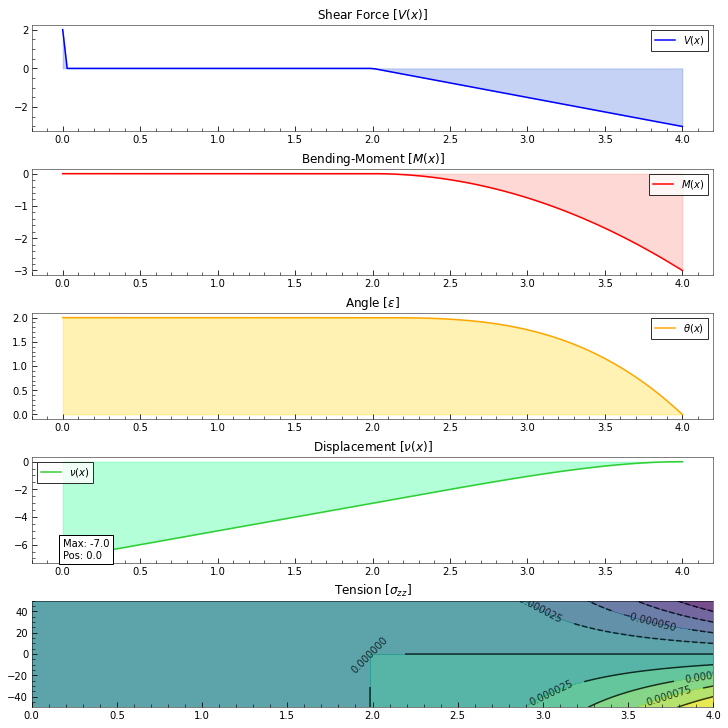

In [23]:
mosaic = """
AA
BB
CC
DD
EE
"""

fig = plt.figure(constrained_layout=True, figsize=(10, 10))
ax_dict = fig.subplot_mosaic(mosaic)

ax_dict["A"].set_title("Shear Force [$V(x)$]")
ax_dict["A"].plot(x, vx, color="blue", label="$V(x)$")
ax_dict["A"].fill_between(x, vx, alpha=0.3, color="royalblue")
ax_dict["A"].legend()

ax_dict["B"].set_title("Bending-Moment [$M(x)$]")
ax_dict["B"].plot(x, mx, color="red", label="$M(x)$")
ax_dict["B"].fill_between(x, mx, alpha=0.3, color="salmon")
ax_dict["B"].legend()

ax_dict["C"].set_title("Angle [$\epsilon$]")
ax_dict["C"].plot(x, ox, color="orange", label="$\\theta(x)$")
ax_dict["C"].fill_between(x, ox, alpha=0.3, color="gold")
ax_dict["C"].legend()

ax_dict["D"].set_title("Displacement [$\\nu(x)$]")
ax_dict["D"].plot(x, vvx, color="limegreen", label="$\\nu(x)$")
ax_dict["D"].text(x[np.abs(vvx).argmax()], vvx[np.abs(vvx).argmax()],
                  f"Max: {round(vvx[np.abs(vvx).argmax()], 2)}\nPos: {x[np.abs(vvx).argmax()]}",
                  bbox=dict(facecolor='white', edgecolor='black'))
ax_dict["D"].fill_between(x, vvx, alpha=0.3, color="springgreen")
ax_dict["D"].legend()

ax_dict["E"].set_title("Tension [$\sigma_{zz}$]")
fmt = np.format_float_scientific
plot_contour_labels(ax_dict["E"], mesh_x, mesh_y, inertia)

plt.show()

In [85]:
vvx.min()

-333.3126306497506

In [88]:
vvx[np.abs(vvx).argmax()]

-333.3126306497506

In [3]:
BOUNDARY_CONDITIONS = {
    SupportTypes.fixed: {
        "M": "?",
        "V": "?"
    },
    SupportTypes.roller: {
        "M": 80.0,
        "V": "?"
    },
    SupportTypes.pinned: {
        "M": 0.0,
        "V": "?"
    },
    "free": {
        "M": 0.0,
        "V": 0.0
    }
}
b = Beam(L=10)
# b.remove_support(0.0)
b.add_support(Support(0.0, SupportTypes.roller))
b.add_support(Support(10.0, SupportTypes.pinned))
b.add_load(Load(-5, LoadTypes.uniformlyDistributed, 5.0, 10.0))
b.add_load(Load(-15, LoadTypes.centered, 5.0))
model = Model(b, bound_conds=BOUNDARY_CONDITIONS, app=True)
# model = Model(b, app=True)
internal_strain = model.solve()

POSITION CONDITIONS
[(0.0, {'M': 80.0, 'V': '?'}), (10.0, {'M': 0.0, 'V': '?'})]
VALUES:
 [['80.0' '?']
 ['0.0' '?']]
best_positions 02
 [[0.0 {'M': 80.0, 'V': '?'}]
 [10.0 {'M': 0.0, 'V': '?'}]]
{C2: 80.0000000000000, C1: 5.75000000000000}


# Contour plot

In [4]:
import matplotlib.pyplot as plt
from matplotlib import cm

In [5]:
x, v_x, m_x, o_x, vv_x = internal_strain

h = 250 # mm
b = len(x)
# I = (1/12)*b*h**3 # mm^4
I = 91.92e6 # mm^4

y = np.linspace(-h/2, h/2, len(x))
xv, yv = np.meshgrid(x, y)

In [6]:
def plot_contour_labels(ax, x, y, function, f_cmap=cm.viridis, levels=10):
    ax.contourf(x, y, function, cmap=f_cmap, levels=levels, alpha=.75)
    labels = ax.contour(x, y, function, colors="black", levels=levels, alpha=.75)
    
    if np.max(function) > 999:
        ax.clabel(labels, inline=1, fontsize=12, fmt=np.format_float_scientific)
    else:
        ax.clabel(labels, inline=1, fontsize=12)

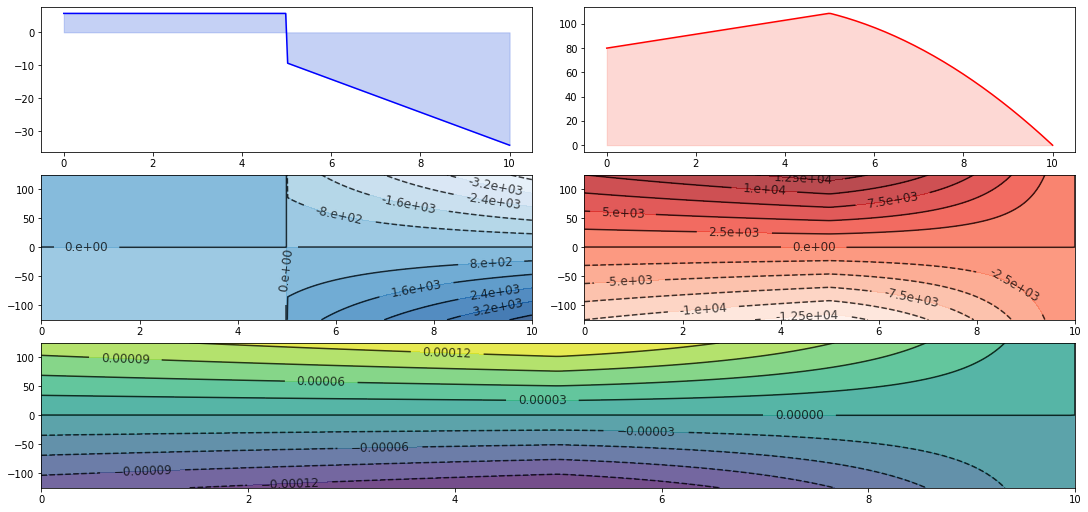

In [7]:
mosaic = """
AABB
CCDD
EEEE
"""

fig = plt.figure(constrained_layout=True, figsize=(15, 7))
ax_dict = fig.subplot_mosaic(mosaic)

ax_dict["A"].plot(x, v_x, color="blue")
ax_dict["A"].fill_between(x, v_x, alpha=0.3, color="royalblue")
ax_dict["B"].plot(x, m_x, color="red")
ax_dict["B"].fill_between(x, m_x, alpha=0.3, color="salmon")

fmt = np.format_float_scientific
plot_contour_labels(ax_dict["C"], xv, yv, v_x * yv, f_cmap=cm.Blues)
plot_contour_labels(ax_dict["D"], xv, yv, m_x * yv, f_cmap=cm.Reds)
plot_contour_labels(ax_dict["E"], xv, yv, (m_x * yv) / I)

plt.show()

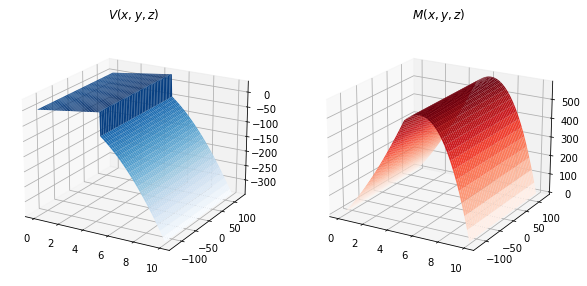

In [8]:
fig, ax = plt.subplots(1, 2, subplot_kw={"projection": "3d"}, figsize=(10, 5))

ax[0].set_title("$V(x, y, z)$")
ax[0].plot_surface(xv, yv, v_x * xv, cmap="Blues")
ax[0].view_init(20, -60)

ax[1].set_title("$M(x, y, z)$")
ax[1].plot_surface(xv, yv, m_x * xv, cmap="Reds")
ax[1].view_init(20, -60)

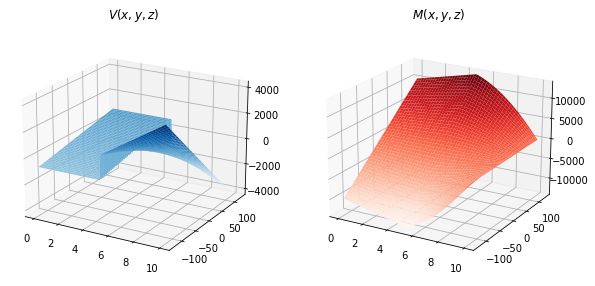

In [9]:
fig, ax = plt.subplots(1, 2, subplot_kw={"projection": "3d"}, figsize=(10, 5))

ax[0].set_title("$V(x, y, z)$")
ax[0].plot_surface(xv, yv, v_x * yv, cmap="Blues")
ax[0].view_init(20, -60)

ax[1].set_title("$M(x, y, z)$")
ax[1].plot_surface(xv, yv, m_x * yv, cmap="Reds")
ax[1].view_init(20, -60)

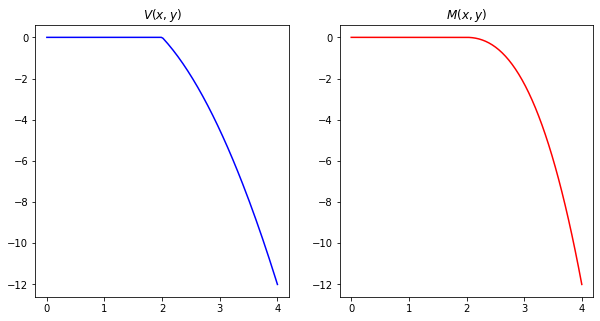

In [19]:
fig, ax = plt.subplots(1, 2, figsize=(10, 5))

ax[0].set_title("$V(x, y)$")
ax[0].plot(x, v_x * x, color="blue")

ax[1].set_title("$M(x, y)$")
ax[1].plot(x, m_x * x, color="red")

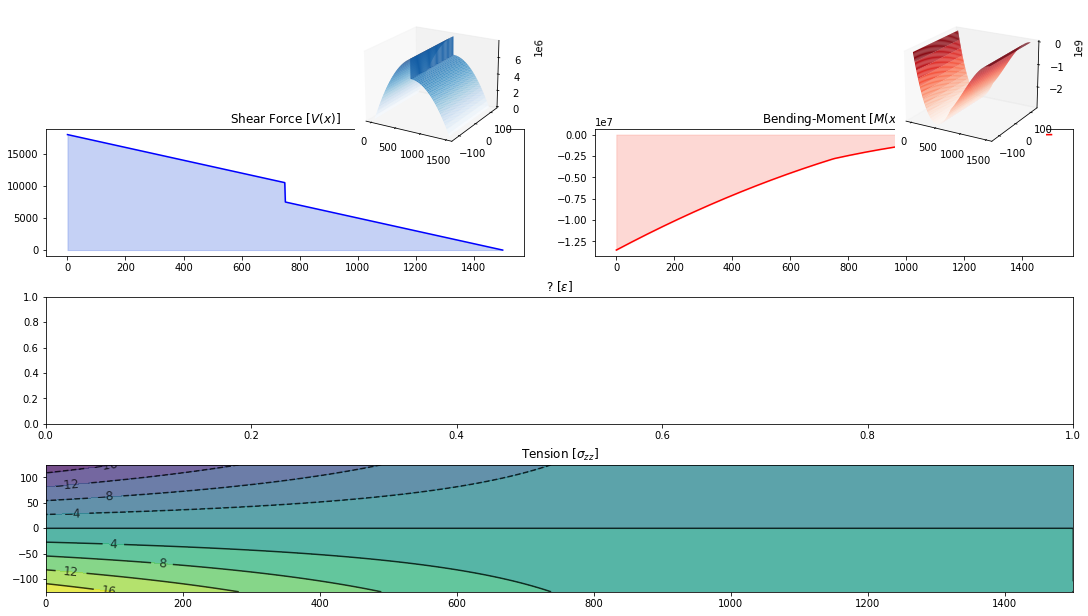

In [10]:
mosaic = [["A", "B"], ["C", "C"], ["D", "D"]]

fig = plt.figure(constrained_layout=True, figsize=(15, 7))
ax_dict = fig.subplot_mosaic(mosaic)

ax_dict["A"].set_title("Shear Force [$V(x)$]")
ax_dict["A"].plot(x, v_x, color="blue")
ax_dict["A"].fill_between(x, v_x, alpha=0.3, color="royalblue")
ax_dict["A"] = fig.add_axes([0.245, 0.9, 0.3, 0.3], projection="3d")
ax_dict["A"].grid(False)
ax_dict["A"].plot_surface(xv, yv, v_x * xv, cmap="Blues")
ax_dict["A"].view_init(20, -60)

ax_dict["B"].set_title("Bending-Moment [$M(x)$]")
ax_dict["B"].plot(x, m_x, color="red")
ax_dict["B"].fill_between(x, m_x, alpha=0.3, color="salmon")
ax_dict["B"] = fig.add_axes([0.745, 0.9, 0.3, 0.3], projection="3d")
ax_dict["B"].grid(False)
ax_dict["B"].plot_surface(xv, yv, m_x * xv, cmap="Reds")
ax_dict["B"].view_init(20, -60)

ax_dict["C"].set_title("? [$\epsilon$]")

ax_dict["D"].set_title("Tension [$\sigma_{zz}$]")
plot_contour_labels(ax_dict["D"], xv, yv, (m_x * yv) / I)

plt.show()

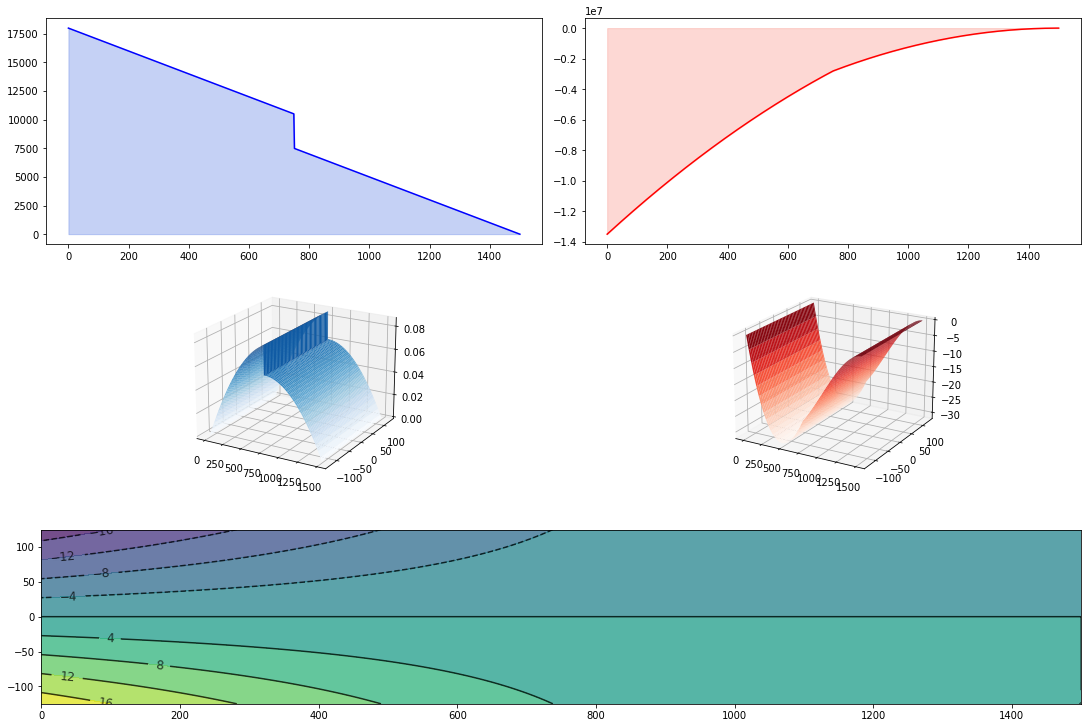

In [11]:
fig = plt.figure(constrained_layout=True, figsize=(15, 10))

ax_v = fig.add_subplot(321)
ax_v.plot(x, v_x, color="blue")
ax_v.fill_between(x, v_x, alpha=0.3, color="royalblue")

ax_m = fig.add_subplot(322)
ax_m.plot(x, m_x, color="red")
ax_m.fill_between(x, m_x, alpha=0.3, color="salmon")

ax_v3d = fig.add_subplot(323, projection="3d")
ax_v3d.plot_surface(xv, yv, (v_x * xv) / I, cmap="Blues")
ax_v3d.view_init(20, -60)

ax_m3d = fig.add_subplot(324, projection="3d")
ax_m3d.plot_surface(xv, yv, (m_x * xv) / I, cmap="Reds")
ax_m3d.view_init(20, -60)

ax_strain = fig.add_subplot(414)
plot_contour_labels(ax_strain, xv, yv, (m_x * yv) / I)

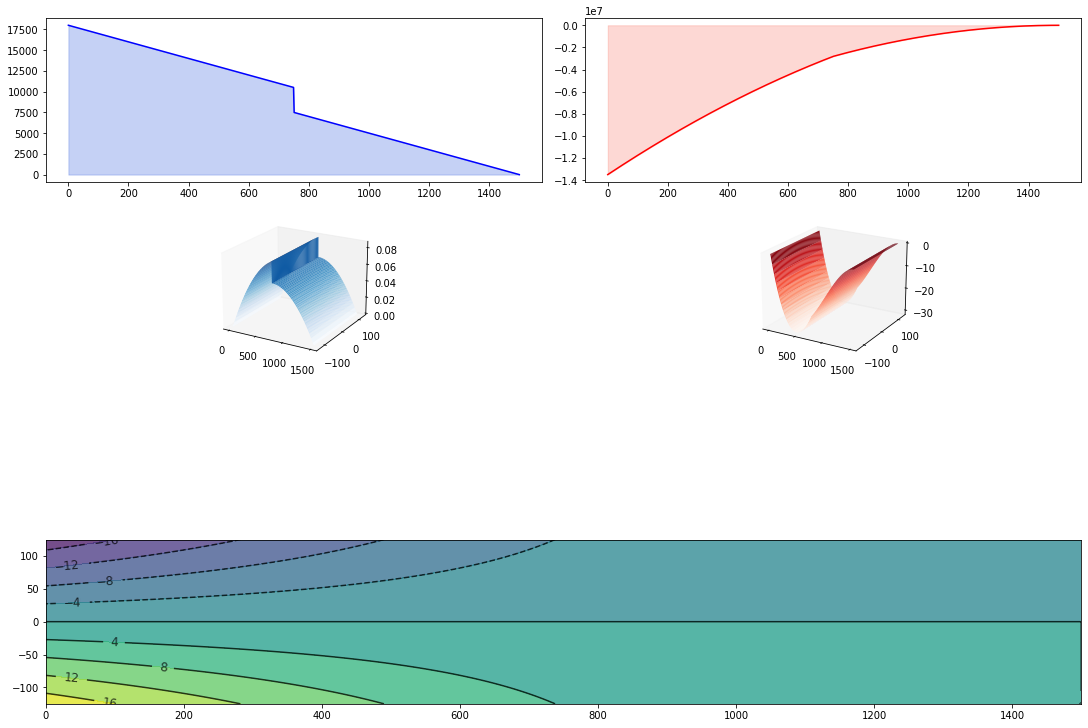

In [12]:
fig = plt.figure(constrained_layout=True, figsize=(15, 10))
grid = plt.GridSpec(4, 4, figure=fig)

ax_v = fig.add_subplot(grid[0, 0:2])
ax_v.plot(x, v_x, color="blue")
ax_v.fill_between(x, v_x, alpha=0.3, color="royalblue")

ax_m = fig.add_subplot(grid[0, 2:4])
ax_m.plot(x, m_x, color="red")
ax_m.fill_between(x, m_x, alpha=0.3, color="salmon")

ax_v3d = fig.add_subplot(grid[1:2, 0:2], projection="3d")
ax_v3d.grid(False)
ax_v3d.plot_surface(xv, yv, (v_x * xv) / I, cmap="Blues")
ax_v3d.view_init(20, -60)

ax_m3d = fig.add_subplot(grid[1:2, 2:4], projection="3d")
ax_m3d.grid(False)
ax_m3d.plot_surface(xv, yv, (m_x * xv) / I, cmap="Reds")
ax_m3d.view_init(20, -60)

ax_strain = fig.add_subplot(grid[3, :])
plot_contour_labels(ax_strain, xv, yv, (m_x * yv) / I)